# Large Scope Analysis

In [1]:
import math
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

qpe = pd.read_csv('./data/QPE.csv')
qpe['datetime'] = pd.to_datetime(qpe['datetime'])

station_data = pd.read_csv('./data/Station_data.csv')
station_data['datetime'] = pd.to_datetime(station_data['datetime'])

## Distribution of AQC values

In [2]:
qpe['aqc'].describe()

count    61823.000000
mean         0.114638
std          0.673917
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000104
max         52.817370
Name: aqc, dtype: float64

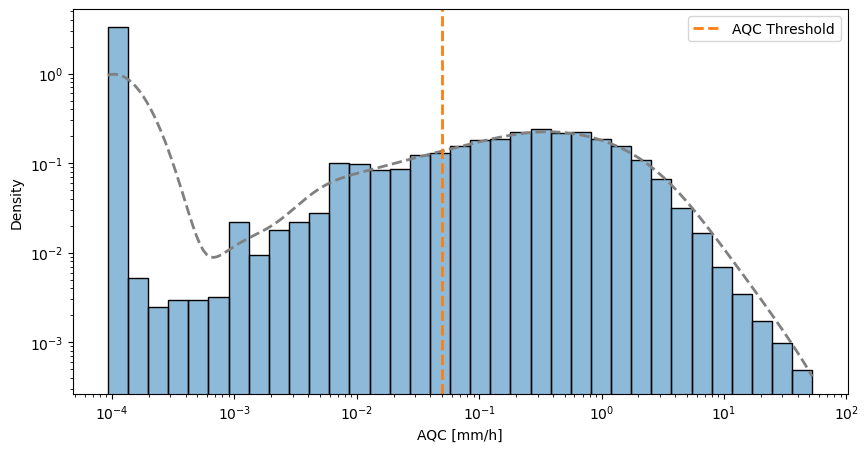

In [3]:
data = qpe['aqc']

# Filter out zero values
non_zero_data = data[data > 0]

plt.figure(figsize=(10, 5))

sns.histplot(non_zero_data, bins=35, kde=True, stat="density", 
             linewidth=1, color='C0', edgecolor='black', log_scale=(True, True))

# Customize KDE line style
plt.setp(plt.gca().lines, color='grey', linestyle='--', linewidth=2)

# Add a vertical line for the AQC threshold
plt.axvline(x=0.05, color='C1', linestyle='--', linewidth=2, label='AQC Threshold')

plt.legend()
plt.xlabel('AQC [mm/h]')
plt.ylabel('Density')
plt.savefig('./figures/PDF_AQC.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Setting the treshold values for event identification

In [4]:
hours = 4
aqc_teshold = 0.05

mask = (qpe['aqc'] > 0.05) & (qpe['precip'] == 0)
qpe_sublimation = qpe[mask]
qpe_sublimation

,aqc,cpc,cpccv,datetime,precip,year
37,0.413881,0.383303,0.636162,2016-01-02 15:00:00,0.0,2016
65,0.152596,0.038330,0.039082,2016-01-03 20:00:00,0.0,2016
76,0.052104,0.070829,0.148592,2016-01-04 08:00:00,0.0,2016
94,0.103962,0.261141,0.299415,2016-01-05 03:00:00,0.0,2016
97,0.103962,0.041388,0.118705,2016-01-05 06:00:00,0.0,2016
...,...,...,...,...,...,...
61744,1.589167,0.346826,1.423418,2023-07-28 15:00:00,0.0,2023
61745,0.127593,0.003510,0.075074,2023-07-28 16:00:00,0.0,2023
61764,0.095185,0.005127,0.067382,2023-07-29 12:00:00,0.0,2023
61765,0.646111,0.013576,0.029957,2023-07-29 13:00:00,0.0,2023


## Methodology to isolate events with AQC > 0.05 mm/h and 4 consecutive hours

1. **Calculate the difference between consecutive datetime values:**

In [5]:
time_diff = qpe['datetime'].diff()

This line calculates the difference between consecutive datetime values in the index of the qpe dataframe. The result, time_diff, is a Series of time deltas (i.e., differences between consecutive datetimes). This will be used to ensure that the data points are consecutive in time.

2. **Create the `mask_hourly`:**

In [6]:
mask_hourly = (time_diff == pd.Timedelta(hours=1)) | (mask & ~mask.shift(1).fillna(False))

This line creates a new mask, mask_hourly, which has two main components:

- `time_diff == pd.Timedelta(hours=1)`: This checks if the difference between consecutive datetime values is exactly 1 hour. It ensures that the data points are consecutive in time.

- `(~mask.shift(1).fillna(False)) & mask`: This checks for the start of a sublimation event. It's `True` when the previous hour doesn't meet the sublimation condition `(~mask.shift(1).fillna(False))` but the current hour does (`mask`). This ensures that the first hour of each sublimation event is included, even if there's a time gap before it.

3. **Combine the initial mask with mask_hourly:**

In [7]:
mask_consecutive = mask & mask_hourly

This line creates a new mask, `mask_consecutive`, which is `True` only for rows where both the initial sublimation condition is met (`mask`) and the conditions in `mask_hourly` are met. This ensures that we're looking at potential sublimation events where the data points are either consecutive in time or it's the start of an event.

4. **Identify consecutive hours:**

In [8]:
consecutive_hours = mask_consecutive.rolling(window=hours).sum()
mask_at_least_three = consecutive_hours >= hours

This part identifies groups of at least 4 consecutive hours that meet the sublimation condition. The rolling window of size 4 sums up the boolean values in `mask_consecutive`. If 4 consecutive hours meet the condition, the sum for the fourth hour will be 4. Thus, `mask_three_consecutive` will be `True` for the fourth hour of every such event.

`mask_consecutive`: This is a boolean Series (a Series with `True` and `False` values). A `True` value in this Series indicates that the current row meets the sublimation condition and is 1 hour apart from the previous row. In other words, it's part of a consecutive sequence of sublimation events.

`.rolling(window=3)`: It allows to apply a function (like a sum, mean, etc.) over a rolling window of a specified size. In this case, the window size is 4. This means that for each position `i` in the Series, it will consider the values at positions `i`, `i-1`, `i-2` and `i-3` (i.e., the current value and the three preceding values).

`.sum()`: This calculates the sum of values within each rolling window. Since `mask_consecutive` is a boolean Series, `True` values are treated as 1 and `False` values are treated as 0. So, the sum will give the number of `True` values within each window.

5. **Expand to capture all hours of the event:**

This part ensures that all hours of each four-hour event are captured, not just the fourth hour. The shifted masks (`shift(-1)`, `shift(-2)` and `shift(-3)`) mark the third, second and first hours, respectively, of each event. The `|` operator combines these to create a mask that's `True` for all hours of each event.

In [9]:
mask_expanded = mask_at_least_three
for _ in range(hours-1):  # Expanding for the first hours of the event
    mask_expanded |= mask_expanded.shift(-1)

In [10]:
qpe_sublimation_consecutive = qpe[mask_expanded]
qpe_sublimation_consecutive

,aqc,cpc,cpccv,datetime,precip,year
129,0.070829,0.041388,0.047918,2016-01-06 15:00:00,0.0,2016
130,0.177913,0.164769,0.195074,2016-01-06 16:00:00,0.0,2016
131,0.130881,0.048255,0.145176,2016-01-06 17:00:00,0.0,2016
132,0.121211,0.024185,0.150146,2016-01-06 18:00:00,0.0,2016
1156,0.152596,0.152596,0.152139,2016-02-20 07:00:00,0.0,2016
...,...,...,...,...,...,...
59265,0.142037,0.002975,0.131244,2023-04-11 20:00:00,0.0,2023
59270,0.124352,0.000688,0.011675,2023-04-12 02:00:00,0.0,2023
59271,0.176296,0.000553,0.008837,2023-04-12 03:00:00,0.0,2023
59272,0.126296,0.000712,0.011396,2023-04-12 04:00:00,0.0,2023


In [11]:
qpe_sublimation_consecutive.describe()

,aqc,cpc,cpccv,precip,year
count,301.000000,301.000000,300.000000,301.0,301.000000
mean,0.247344,0.051369,0.125429,0.0,2019.189369
std,0.192060,0.103825,0.133186,0.0,2.086629
min,0.052890,0.000518,0.004704,0.0,2016.000000
25%,0.110469,0.006075,0.043705,0.0,2017.000000
50%,0.189207,0.020743,0.083331,0.0,2019.000000
75%,0.328757,0.045806,0.152084,0.0,2021.000000
max,1.219139,1.144940,1.144940,0.0,2023.000000


Here we can see that the filtering succesfully isolated the cases of interest. Precipitation measured at the ground only shows null values, and AQC values show a minimum value larger than 0.05 mm/h

6. **Seperate the resulting DataFrame into a list of DataFrames, each corresponding to one event:**

In [12]:
def split_into_events(df):
    events = []
    current_event = []

    for i, row in df.iterrows():
        if not current_event:
            current_event.append(row)
        else:
            # Calculate the time difference between the current row and the last row of the current event
            time_diff = row['datetime'] - current_event[-1]['datetime']

            if time_diff == pd.Timedelta(hours=1):
                current_event.append(row)
            else:
                # When the time difference is not 1 hour, start a new event
                events.append(pd.DataFrame(current_event))
                current_event = [row]

    # Adding the last event if it's not empty
    if current_event:
        events.append(pd.DataFrame(current_event))

    return events


events = split_into_events(qpe_sublimation_consecutive)

7. **Identify the number of events obtained and represent them visually:**

In [13]:
number_of_events = len(events)
number_of_events 

63

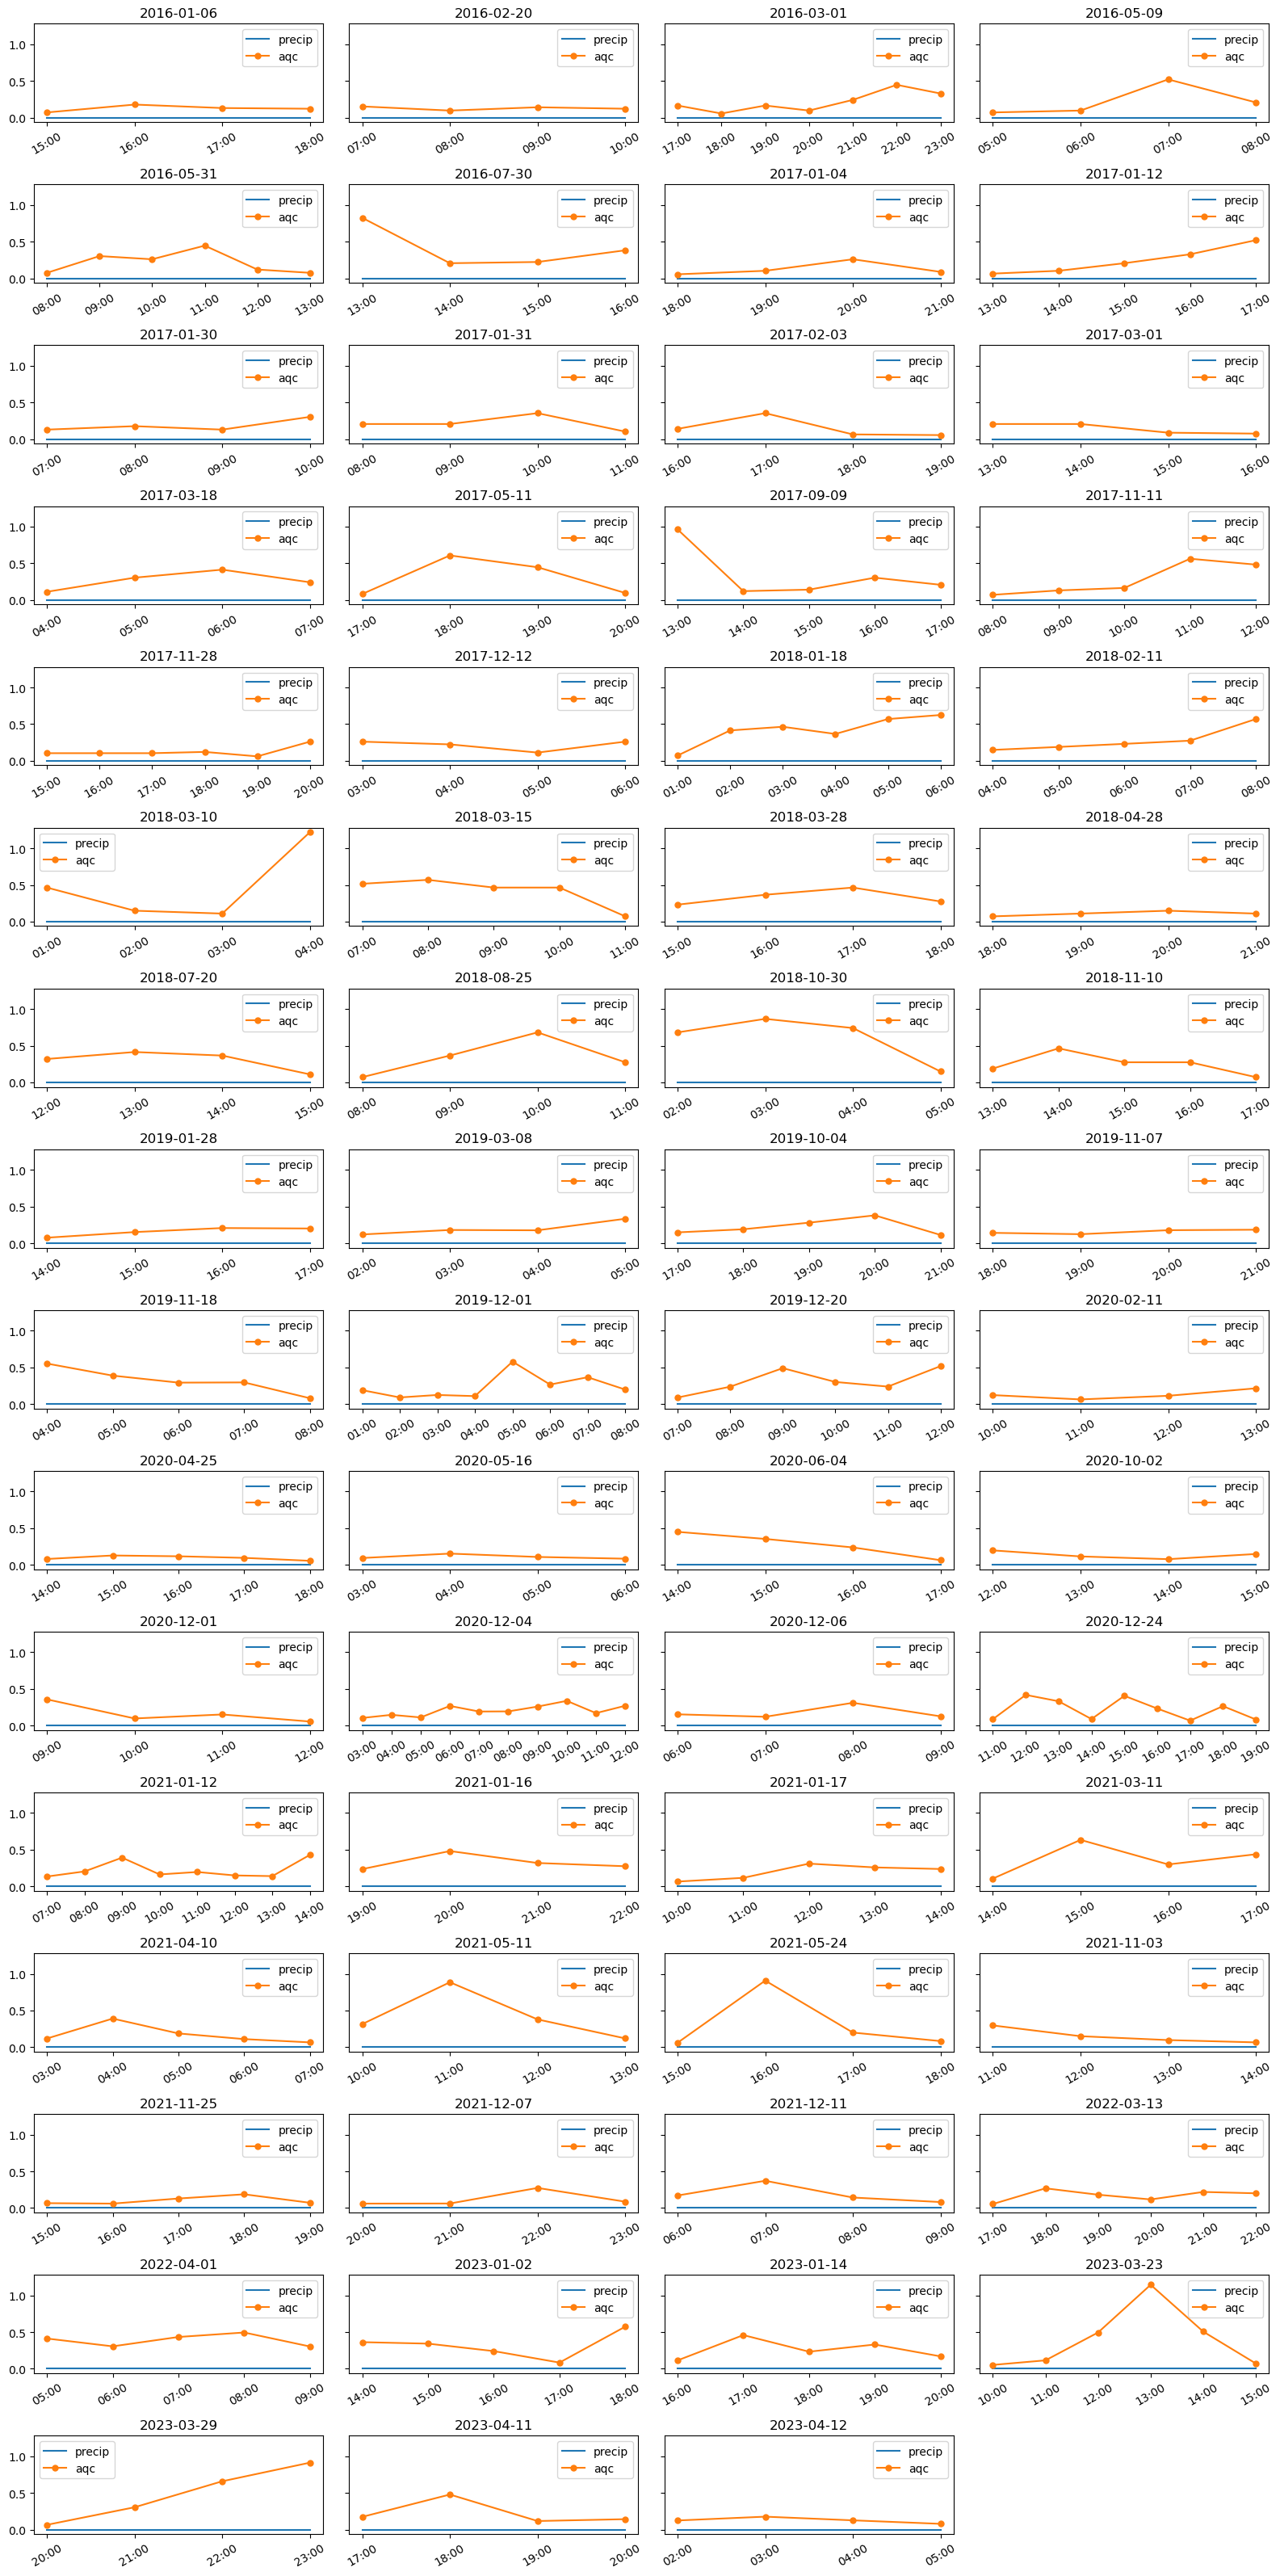

In [14]:
rows = math.ceil(number_of_events / 4)
fig, axs = plt.subplots(rows, 4, figsize=(16, 2*rows), sharey=True)

# Flatten the axes array for easier iteration
axs = axs.ravel()

for i, event in enumerate(events):
    axs[i].plot(event['datetime'], event['precip'], label='precip')
    axs[i].plot(event['datetime'], event['aqc'], label='aqc', marker='o', markersize=5)

    # Extracting the date from the index and setting it as the title
    date = event['datetime'].iloc[0].strftime('%Y-%m-%d')
    axs[i].set_title(date)
    
    axs[i].legend()
    axs[i].xaxis.set_major_locator(mdates.HourLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate x-tick labels
    axs[i].tick_params(axis='x', rotation=30)

# Hide any unused subplots if the number of events is not a multiple of 4
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/sublimation_events_large.pdf', dpi=600, bbox_inches='tight')
plt.show()

## Descriptive Statistics

### Magnitudes and Durations 

In [15]:
durations = [] 
magnitudes = []
for event in events:
    event_duration = len(event)
    durations.append(event_duration)
    
    event_magnitude = round(event['aqc'].max(), 4)
    magnitudes.append(event_magnitude)

    
print(magnitudes)

[0.1779, 0.1526, 0.4469, 0.521, 0.4469, 0.8258, 0.2611, 0.521, 0.3045, 0.355, 0.355, 0.2074, 0.4139, 0.6075, 0.9628, 0.5626, 0.2611, 0.2611, 0.6245, 0.5692, 1.2191, 0.5692, 0.4641, 0.1487, 0.4142, 0.6818, 0.8661, 0.4641, 0.2068, 0.3332, 0.3797, 0.184, 0.5513, 0.5778, 0.5165, 0.2138, 0.1272, 0.1528, 0.4491, 0.1965, 0.3577, 0.3373, 0.3106, 0.4186, 0.4297, 0.4819, 0.3104, 0.6339, 0.39, 0.8852, 0.9078, 0.2966, 0.1868, 0.2736, 0.371, 0.2681, 0.4947, 0.5739, 0.4593, 1.1449, 0.9123, 0.478, 0.1763]


1. **Bar plot of magnitudes:**

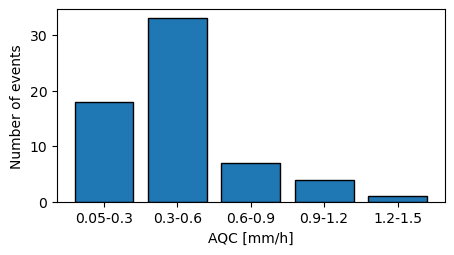

In [16]:
# Define broader intervals and labels
intervals = [(0.05, 0.3), (0.3, 0.6), (0.6, 0.9), (0.9, 1.2), (1.2, 1.5)]
labels = [f"{low}-{high}" for low, high in intervals]

# Count the number of events in each interval
counts = [sum(low < m <= high for m in magnitudes) for low, high in intervals]

plt.figure(figsize=(5, 2.5))
plt.bar(labels, counts, edgecolor='black')
plt.ylabel('Number of events')
plt.xlabel('AQC [mm/h]')
plt.savefig('./figures/Magnitudes_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

2. **Bar plot of durations:**

In [17]:
print(durations)

[4, 4, 7, 4, 6, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 6, 4, 6, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 5, 8, 6, 4, 5, 4, 4, 4, 4, 10, 4, 9, 8, 4, 5, 4, 5, 4, 4, 4, 5, 4, 4, 6, 5, 5, 5, 6, 4, 4, 4]


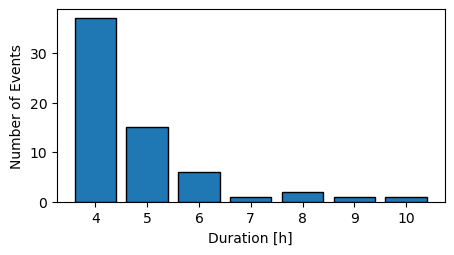

In [18]:
# Set the bins characteristics
bins = np.arange(min(durations) - 0.5, max(durations) + 1.5, 1)

plt.figure(figsize=(5, 2.5))
plt.hist(durations, bins=bins, edgecolor='black', rwidth=0.8)
plt.ylabel('Number of Events')
plt.xlabel('Duration [h]')
plt.savefig('./figures/Durations_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Seasonality and Average Temperatures

1. **Extract the meteorological season and average temperature of each event:**

In [19]:
# Function to determine the season based on the month (meteorological seasons)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Function to get average temperature and season for each event's datetime
def get_average_temperature_and_season(event_df, station_data):
    # Merging the event dataframe with station_data on datetime
    merged_df = pd.merge(event_df, station_data, on='datetime', how='left')

    # Extracting the month from the datetime to determine the season
    merged_df['month'] = merged_df['datetime'].dt.month
    merged_df['season'] = merged_df['month'].apply(get_season)
    
    # Calculating the average temperature for each event datetime
    avg_temperature = merged_df['air_temp'].mean()
    
    # Assuming season is consistent across a single event, taking the first one
    season = merged_df['season'].iloc[0]
    
    return round(avg_temperature, 2), season

# List to store the average temperatures and seasons for each event dataframe
average_temperatures_and_seasons_list = []

# Iterating through each dataframe in the 'events' list
for event_df in events:
    avg_temp, season = get_average_temperature_and_season(event_df, station_data)
    average_temperatures_and_seasons_list.append((avg_temp, season))

In [20]:
print(average_temperatures_and_seasons_list)

[(4.53, 'Winter'), (2.33, 'Winter'), (5.2, 'Spring'), (14.12, 'Spring'), (14.52, 'Spring'), (25.55, 'Summer'), (1.3, 'Winter'), (5.28, 'Winter'), (0.8, 'Winter'), (6.2, 'Winter'), (6.93, 'Winter'), (6.65, 'Spring'), (9.68, 'Spring'), (13.82, 'Spring'), (13.52, 'Autumn'), (8.14, 'Autumn'), (4.02, 'Autumn'), (2.08, 'Winter'), (2.97, 'Winter'), (0.74, 'Winter'), (8.42, 'Spring'), (3.02, 'Spring'), (11.45, 'Spring'), (16.8, 'Spring'), (22.93, 'Summer'), (15.22, 'Summer'), (2.88, 'Autumn'), (7.96, 'Autumn'), (1.88, 'Winter'), (6.6, 'Spring'), (12.3, 'Autumn'), (5.7, 'Autumn'), (2.44, 'Autumn'), (2.42, 'Winter'), (2.28, 'Winter'), (7.78, 'Winter'), (17.02, 'Spring'), (7.08, 'Spring'), (15.5, 'Summer'), (13.3, 'Autumn'), (2.95, 'Winter'), (0.96, 'Winter'), (1.4, 'Winter'), (7.02, 'Winter'), (-0.64, 'Winter'), (-0.88, 'Winter'), (2.2, 'Winter'), (13.2, 'Spring'), (7.4, 'Spring'), (12.1, 'Spring'), (14.58, 'Spring'), (6.65, 'Autumn'), (2.7, 'Autumn'), (2.28, 'Winter'), (1.58, 'Winter'), (10.28,

2. **Plot monthly distribution of events:**

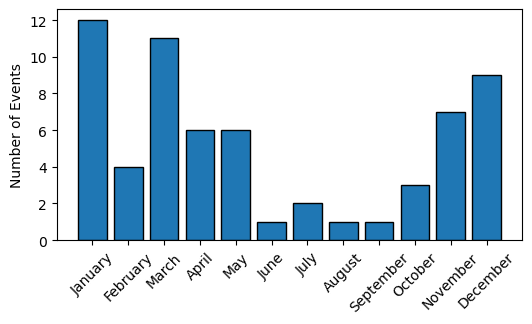

In [21]:
# Step 1: Extract the month for each event's start date
event_months = [event_df['datetime'].min().month for event_df in events]

# Step 2: Count the number of events per month
events_per_month = pd.Series(event_months).value_counts().sort_index()

# Step 3: Create the bar plot
plt.figure(figsize=(6, 3))
plt.bar(events_per_month.index, events_per_month, edgecolor='black')
plt.ylabel('Number of Events')
plt.xticks(ticks=range(1, 13), 
           labels=[calendar.month_name[i] for i in range(1, 13)], 
           rotation=45)
plt.savefig('./figures/seasonality.pdf', dpi=300, bbox_inches='tight')
plt.show()

3. **Plot the comparative distributions of average temperatures during events in winter and other seasons:**

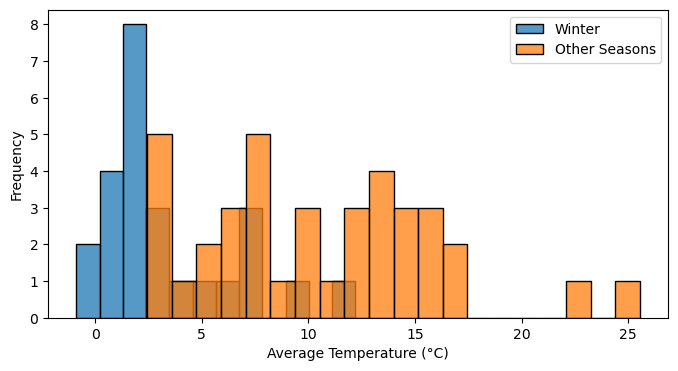

In [22]:
# Separating winter temperatures and other seasons temperatures
winter_temps = [temp for temp, season in average_temperatures_and_seasons_list if season == 'Winter']
other_seasons_temps = [temp for temp, season in average_temperatures_and_seasons_list if season != 'Winter']

plt.figure(figsize=(8, 4))

# Histogram for winter temperatures
sns.histplot(winter_temps, bins=12, edgecolor='black', label='Winter')

# Histogram for other seasons temperatures
sns.histplot(other_seasons_temps, bins=20, edgecolor='black', label='Other Seasons')

plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('./figures/avg_temp_seasons.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Seasonality of Relative Humidity during non-zero AQC timesteps

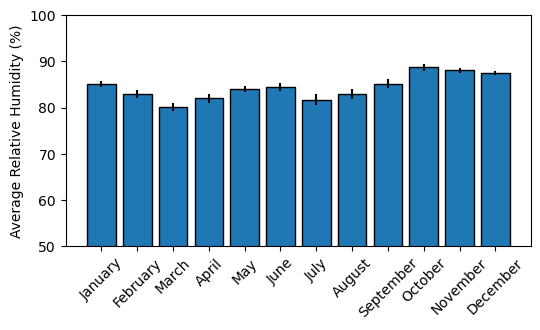

In [23]:
# Step 1: Filter 'qpe' DataFrame for AQC values > 0.05
qpe_filtered = qpe[qpe['aqc'] > 0.05]

# Step 2: Join with 'station_data' on 'datetime'
joined_data = pd.merge(station_data, qpe_filtered, on='datetime', how='inner')

# Step 3: Extract month and group by it
joined_data['month'] = joined_data['datetime'].dt.month
monthly_avg_rh = joined_data.groupby('month')['rh'].agg(['mean', 'sem'])

# Convert the month number to month name for better readability in the plot
monthly_avg_rh.index = monthly_avg_rh.index.map(lambda x: pd.to_datetime(x, format='%m').strftime('%B'))

# Step 4: Plotting with Bar Plot
ci = 1.96 * monthly_avg_rh['sem']  # 95% CI for the error bars
plt.figure(figsize=(6, 3))

# Create bar plot
plt.bar(monthly_avg_rh.index, monthly_avg_rh['mean'], color='C0', edgecolor='black')

# Add error bars for the confidence intervals
plt.errorbar(monthly_avg_rh.index, monthly_avg_rh['mean'], yerr=ci, fmt='', color='black', capsize=0, linestyle='none')

plt.ylim(50, 100)
plt.ylabel('Average Relative Humidity (%)')
plt.xticks(rotation=45) 
plt.savefig('./figures/relative_humidity_seasonality.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Event classification

1. **Creating a 'classification' column for each event:**

In [24]:
for event_df in events:
    # Initialize the classification for each event
    classification = 'isolated'

    # Find the start and end times of the event
    event_start_time = event_df['datetime'].min()
    event_end_time = event_df['datetime'].max()

    # Define the time windows: two hours before the start and two hours after the end of the event
    two_hours_before_start = event_start_time - pd.Timedelta(hours=2)
    two_hours_after_end = event_end_time + pd.Timedelta(hours=2)

    # Extract relevant precipitation data from 'qpe'
    before_event_precip = qpe[(qpe['datetime'] >= two_hours_before_start) & (qpe['datetime'] < event_start_time)]
    after_event_precip = qpe[(qpe['datetime'] > event_end_time) & (qpe['datetime'] <= two_hours_after_end)]

    # Classification logic
    if before_event_precip['precip'].sum() > 0 and after_event_precip['precip'].sum() > 0:
        classification = 'within-precipitation'
    elif before_event_precip['precip'].sum() > 0:
        classification = 'post-precipitation'
    elif after_event_precip['precip'].sum() > 0:
        classification = 'pre-precipitation'

    # Add classification to the event DataFrame
    event_df['classification'] = classification

# Now, each DataFrame in 'events' has an additional 'classification' column

2. **Count the number of events in each category:**

In [25]:
# Initialize a dictionary to hold counts for each classification category
classification_counts = {
    'pre-precipitation': 0,
    'post-precipitation': 0,
    'within-precipitation': 0,
    'isolated': 0
}

# Iterate through each event DataFrame and count the classifications
for event_df in events:
    classification = event_df['classification'].iloc[0]
    classification_counts[classification] += 1

# Convert the dictionary to a DataFrame
classification_summary_df = pd.DataFrame(list(classification_counts.items()), columns=['Classification', 'Count'])

# Add a percentage column
classification_summary_df['Percentage'] = 100*(classification_summary_df['Count']/classification_summary_df['Count'].sum())

classification_summary_df

,Classification,Count,Percentage
0,pre-precipitation,30,47.619048
1,post-precipitation,8,12.698413
2,within-precipitation,4,6.349206
3,isolated,21,33.333333


3. **Plot the results:**

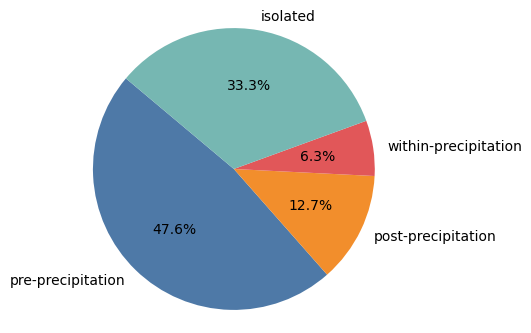

In [26]:
labels = classification_summary_df['Classification']
sizes = classification_summary_df['Count']
colors = ['#4e79a7', '#f28e2c', '#e15759', '#76b7b2']

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors = colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('./figures/event_classification.pdf', dpi=300, bbox_inches='tight')
plt.show()